In [1]:
import requests
import os
import json
import pandas as pd
import openai
from openai import OpenAI
from newspaper import Article
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Set your Bearer Token
bearer_token = "..."

query = "pyme"

#Language of the tweets we will be searching
lang = "es"

#The maximum ammount of tweets to be retrieved
max_results = 100

In [ ]:
# Define the Twitter API endpoint
search_url = "https://api.twitter.com/2/tweets/search/recent"


# Define the query parameters
query_params = {
    f'{query}': f'pyme {lang}:es -is:retweet',  # Search for "pyme" tweets in Spanish, excluding retweets
    'tweet.fields': 'author_id,created_at,text',  # Fields to include in the response
    'max_results': max_results,  # Number of tweets to fetch
    
}

def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """
    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2TweetSearchPython"
    return r

def connect_to_endpoint(url, params):
    """
    Connect to the Twitter API endpoint and fetch results.
    """
    response = requests.get(url, auth=bearer_oauth, params=params)
    print(f"HTTP Status Code: {response.status_code}")
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

# Fetch tweets from the endpoint
try:
    json_response = connect_to_endpoint(search_url, query_params)
    print(json.dumps(json_response, indent=4, sort_keys=True))
    
    # Create a DataFrame
    if "data" in json_response:
        df = pd.DataFrame(json_response["data"])
        print(df)
        # Save to CSV
        df.to_csv("tweets.csv", index=False)
        print("Tweets saved to tweets.csv")
    else:
        print("No tweets found.")
except Exception as e:
    print(f"Error: {e}")


In [36]:
df.head()

,edit_history_tweet_ids,id,created_at,author_id,text
0,['1875381195351191587'],1875381195351191587,2025-01-04T03:18:14.000Z,1389369926259990534,@EnmanuelRM_ @SuperdeBancosRD Pero realmente e...
1,['1875373933522018433'],1875373933522018433,2025-01-04T02:49:23.000Z,1459999153422053381,@Sinfiltros_tv Hasta el dueño de pyme más pequ...
2,['1875367464063901881'],1875367464063901881,2025-01-04T02:23:40.000Z,3090258327,"@gus_bs Sacando la casta/Rigi Massa,Vila Manza..."
3,['1875366269022785894'],1875366269022785894,2025-01-04T02:18:55.000Z,366373550,@KichaChilena De seguro nos enteramos pronto q...
4,['1875355204725698644'],1875355204725698644,2025-01-04T01:34:57.000Z,1694500396318773248,@PabloRossiLN José cree que todos los que prod...


La forma mas fiel de analizar los sentimientos de nuestra base de datos de tweets seria a mano, sin embargo como esto llevaria mucho tiempo, optamos por llamar a la API de ChatGPT para analizar cada uno de ellos y determinar su sentimiento, ya que es el estandar de industria en cuanto a capacidad de analisis de sentimiento entre varias otras cosas.

In [52]:
client = OpenAI(api_key="...")

#Guardamos el prompt al cual le agregaremos el texto del tweet para luego llamar a ChatGPT
prompt = f"Voy a mostrarte un tweet que habla de'{query}'analiza el sentimiento y responde solamente una de las siguientes 5 palabras sin un punto al final: 'muy positivo','positivo','neutral','negativo','muy negativo'. El tweet es el siguient:"

sentiment = []
    
for index,row in df.iterrows():
    prompt_temp = prompt + row["text"]


    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
        {"role": "user", "content": f"{prompt_temp}"}])
            
    sentiment.append(completion.choices[0].message.content)

sentiment
df["sentiment"] = sentiment
df.head()

,edit_history_tweet_ids,id,created_at,author_id,text,sentiment
0,['1875381195351191587'],1875381195351191587,2025-01-04T03:18:14.000Z,1389369926259990534,@EnmanuelRM_ @SuperdeBancosRD Pero realmente e...,positivo
1,['1875373933522018433'],1875373933522018433,2025-01-04T02:49:23.000Z,1459999153422053381,@Sinfiltros_tv Hasta el dueño de pyme más pequ...,positivo
2,['1875367464063901881'],1875367464063901881,2025-01-04T02:23:40.000Z,3090258327,"@gus_bs Sacando la casta/Rigi Massa,Vila Manza...",negativo
3,['1875366269022785894'],1875366269022785894,2025-01-04T02:18:55.000Z,366373550,@KichaChilena De seguro nos enteramos pronto q...,negativo
4,['1875355204725698644'],1875355204725698644,2025-01-04T01:34:57.000Z,1694500396318773248,@PabloRossiLN José cree que todos los que prod...,negativo


Debemos revisar que las categorias con las que el modelo ha clasificado nuestros tweets efectivamente son las correctas, para esto miramos sus valores unicos y hacemos las correciones necesarias.

In [ ]:
# Get unique values and their counts
unique_counts = df['sentiment'].value_counts()

# Print the result
print(unique_counts)

In [53]:
# Remove capital letters and periods from the 'sentiment' column
df['sentiment'] = df['sentiment'].str.replace(r'[A-Z]', '', regex=True)  # Remove uppercase letters
df['sentiment'] = df['sentiment'].str.replace(r'\.', '', regex=True)  # Remove periods
df['sentiment'] = df['sentiment'].str.replace(r'neutro', 'neutral', regex=True)  # Remove periods

df['sentiment'] = df['sentiment'].apply(lambda x: 'negativo' if x == 'egativo' else x)
df['sentiment'] = df['sentiment'].apply(lambda x: 'positivo' if x == 'ositivo' else x)

In [54]:
# Get unique values and their counts
unique_counts = df['sentiment'].value_counts()

# Print the result
print(unique_counts)

sentiment
negativo        52
positivo        30
neutral         17
muy positivo     1
Name: count, dtype: int64


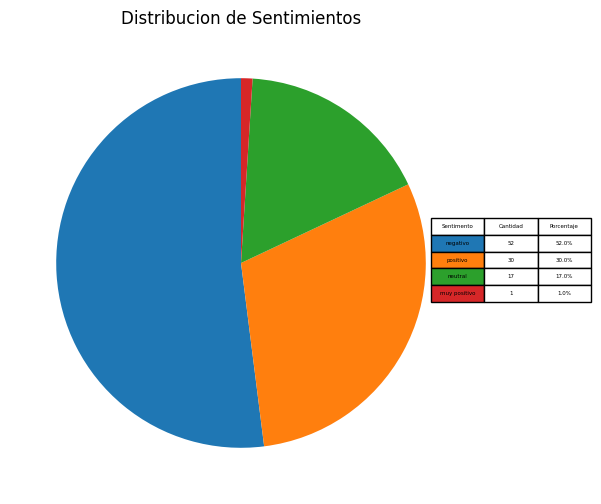

In [56]:
# Count unique values and calculate percentages
value_counts = df['sentiment'].value_counts()
percentages = 100 * value_counts / value_counts.sum()

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 6))

# Generate the pie chart and extract wedge colors
wedges, _ = ax.pie(value_counts, startangle=90, labels=None)
colors = [w.get_facecolor() for w in wedges]

# Create a table for the side
table_data = {
    'Sentiment': value_counts.index,
    'Count': value_counts.values,
    'Percentage': [f"{p:.1f}%" for p in percentages],
    'Color': [''] * len(colors)  # Empty placeholder for the table (colors are visual)
}

# Convert table data to a DataFrame
table_df = pd.DataFrame(table_data)

# Add the table next to the pie chart
table_ax = fig.add_axes([0.75, 0.2, 0.2, 0.6])  # [left, bottom, width, height]
table_ax.axis('off')
mpl_table = table_ax.table(
    cellText=table_df[['Sentiment', 'Count', 'Percentage']].values,
    colLabels=['Sentimento', 'Cantidad', 'Porcentaje'],
    loc='center',
    cellLoc='center',
    colLoc='center'
)

# Set colors for the corresponding rows
for (row, color) in zip(range(1, len(colors) + 1), colors):
    mpl_table[(row, 0)].set_facecolor(color)

# Add title
ax.set_title('Distribucion de Sentimientos')

# Save the figure with high resolution
fig.savefig('distribucion_sentimientos.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [6]:
import locale
from datetime import datetime

#Creamos el dataframe que luego usaremos en nuestro fine-tunning
df_FT = df.drop(columns=['edit_history_tweet_ids','id','created_at','author_id'])

# Set the locale to Spanish
locale.setlocale(locale.LC_TIME, 'es_ES.utf8')  # Use 'es_ES' for Spain or adjust for your system

# Get the current date
current_date = datetime.now()

# Format the date as #day_MonthName in Spanish
fecha = f"_{current_date.day}_{current_date.strftime('%B')}"

def df_to_excel(nombre_archivo, df):
    """
    Saves a DataFrame to an Excel file.
    
    Parameters:
    - nombre_archivo (str): The name of the file to save the DataFrame to.
    - df (pd.DataFrame): The DataFrame to save.
    """
    try:
        # Save the DataFrame to an Excel file
        df.to_excel(nombre_archivo, index=False)
        print(f"El DataFrame se ha guardado en el archivo {nombre_archivo}")
    except Exception as e:
        print(f"Error guardando el DataFrame: {e}")

df_to_excel(f'analsisDeSentimientoRedes{fecha}.xlsx',df_FT)

El DataFrame se ha guardado en el archivo analsisDeSentimientoRedes_5_enero.xlsx


In [5]:
df_FT.head()

,text,sentiment
0,@EnmanuelRM_ @SuperdeBancosRD Pero realmente e...,positivo
1,@Sinfiltros_tv Hasta el dueño de pyme más pequ...,positivo
2,"@gus_bs Sacando la casta/Rigi Massa,Vila Manza...",negativo
3,@KichaChilena De seguro nos enteramos pronto q...,negativo
4,@PabloRossiLN José cree que todos los que prod...,negativo
